### Problema

A empresa de data science foi contratada para desenvolver um algoritmo que maximize as campanhas de CRM de uma empresa que vende acessórios para veículos.
Com base no histórico de compras, foram desenvolvidas campanhas específicas para atingir um grupo restrito de clientes e garantir o máximo de adesão possível.
Para tanto, clientes foram clusterizados em três níveis:
- Família: classe de veículo (Carro, Moto, Caminhão ou Off-Road)
- Grupo: conjunto de produtos por interesse. Por exemplo, acessórios para lataria e adesivação (“lataria_adesivacao”) inclui cera, adesivos para veiculos, produtos anti-riscos, etc.  
- Subgrupo: subdivisão por categorias de produtos. Por exemplo: produtos premium, básico, high-end

Como forma de garantir que as campanhas tiveram um impacto positivo no hábito de consumo dos clientes, uma parte dos clientes de cada campanha foi alocado em grupos de controle. Este grupo não recebeu as campanhas da ação de CRM.

### Objetivo

O objetivo deste trabalho é apresentar os resultados ao cliente em dashboard e um rápido sumário em formato de apresentação. Para a entrega deste trabalho, pode-se usar qualquer ferramenta (microsoft excel, google sheets, tableau, powerbi, microsoft powerpoint, google presentation, etc). 
Segue abaixo algumas perguntas para ajudar na construção:
- Como organizar a demonstração dos resultados (top down ou bottom up) ? 
- Qual a mensagem a ser passada ? Qual nível de detalhe necessário abrir de forma a transmitir a mensagem sem perder a atenção do cliente (mes a mes, por familia/grupo/subgrupo, por campanha) ? 
- Quais os principais KPIs necessários para mostrar os resultados de CRM ? 
- Como isolar o efeito das campanhas de CRM nos resultados auferidos pelos KPIs ? 
- Mesmo que as campanhas sejam um sucesso, o investimento realizado (em descontos) retornou ao cliente ? 
- Qual métrica usaria para esta análise ?

### Descrição da tabela


- 'anomes' - Ano e mês do disparo da campanha (campanhas pode ter sido disparadas em mais de um mês)
- 'codcamp' - Código da campanha
- 'codcliente' - Identificador do cliente
- 'familia' - vide info acima 
- 'grupo' - vide info acima,
- 'subgrupo' - vide acima,
- 'gt' - True (pertencente ao grupo que recebe campanha), False (pertencente ao grupo que não recebe campanha - Grupo de Controle)
- 'validade_de' - data de início da campanha, 
- 'validade_ate' - data de fim da campanha
- 'fat' - faturamento gerado pelo cliente no período da campanha
- 'fat_bl' - faturamento gerado pelo cliente no mês anterior a campanha (baseline)
- 'lucro' - lucro gerado pelo cliente no período da campanha
- 'lucro_bl' - lucro gerado pelo cliente no mês anterior a campanha (baseline)
- 'custo' - Desconto concedido sobre os produtos promocionados

<b>Dica:</b> Caso o cliente com classe gt = “True” não tenha custo, isto significa que o cliente foi a loja porém não usou os descontos recebidos pela campanha

## Limpeza dos dados

##### Bibliotecas

In [306]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [307]:
dados = pd.read_csv('data_crm.csv', delimiter=';', index_col=0, decimal=',')

In [308]:
dados

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,202003,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,NaN
1,202003,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,NaN,461.30,NaN,181.38,NaN
2,202003,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,NaN
3,202003,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,NaN,43.49,NaN,NaN
4,202003,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,NaN,220.56,NaN,27.03,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633229,202006,B0000000566,59568503,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,NaN,364.68,NaN,109.77,NaN
1633230,202006,B0000000566,59570312,moto,lataria_adesivacao,high_end,True,2020-05-18,2020-06-18,68.30,39.29,25.30,10.64,NaN
1633231,202006,B0000000566,59573779,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,43.88,NaN,19.30,NaN,NaN
1633232,202006,B0000000566,59573798,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,NaN,NaN,NaN,NaN,NaN


##### Informações Gerais sobre os Dados

In [309]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633234 entries, 0 to 1633233
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   anomes        1633234 non-null  int64  
 1   codcamp       1633234 non-null  object 
 2   codcliente    1633234 non-null  object 
 3   familia       1633234 non-null  object 
 4   grupo         1633234 non-null  object 
 5   subgrupo      1633234 non-null  object 
 6   gt            1633234 non-null  bool   
 7   validade_de   1633234 non-null  object 
 8   validade_ate  1633234 non-null  object 
 9   fat           728128 non-null   float64
 10  fat_bl        919083 non-null   float64
 11  lucro         728128 non-null   float64
 12  lucro_bl      919083 non-null   float64
 13  custo         89146 non-null    float64
dtypes: bool(1), float64(5), int64(1), object(7)
memory usage: 176.0+ MB


- Datas estão com objects e int64

In [310]:
dados.describe()

,anomes,fat,fat_bl,lucro,lucro_bl,custo
count,1.633234e+06,728128.000000,919083.000000,728128.000000,919083.000000,89146.000000
mean,2.020049e+05,181.575813,180.525671,64.691228,65.814459,8.516768
std,1.167238e+00,212.821869,211.189297,192.033473,228.771309,15.244468
min,2.020030e+05,-5269.360000,-4589.730000,-72780.460000,-151489.040000,-70.653000
25%,2.020040e+05,64.710000,62.980000,22.090000,21.820000,1.497000
50%,2.020050e+05,128.990000,127.540000,44.180000,43.890000,3.639000
75%,2.020060e+05,231.790000,229.810000,80.650000,81.050000,9.514750
max,2.020060e+05,20038.780000,14363.720000,7674.570000,10039.550000,1142.580000


- Valores financeiros negativos

##### Transformando as datas em formato de data (datetime)

In [311]:
dados['validade_de'] = pd.to_datetime(dados['validade_de'], format='%Y-%m-%d')
dados['validade_ate'] = pd.to_datetime(dados['validade_ate'], format='%Y-%m-%d')
dados['anomes'] = pd.to_datetime(dados['anomes'], format='%Y%m')

##### Conferindo se há valores nulos

In [312]:
dados.isna().sum()

anomes                0
codcamp               0
codcliente            0
familia               0
grupo                 0
subgrupo              0
gt                    0
validade_de           0
validade_ate          0
fat              905106
fat_bl           714151
lucro            905106
lucro_bl         714151
custo           1544088
dtype: int64

##### Preenchendo valores nulos com 0

In [313]:
dados.fillna(0, inplace=True)

In [314]:
dados

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
1,2020-03-01,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,461.30,0.00,181.38,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
4,2020-03-01,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,220.56,0.00,27.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633229,2020-06-01,B0000000566,59568503,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,364.68,0.00,109.77,0.0
1633230,2020-06-01,B0000000566,59570312,moto,lataria_adesivacao,high_end,True,2020-05-18,2020-06-18,68.30,39.29,25.30,10.64,0.0
1633231,2020-06-01,B0000000566,59573779,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,43.88,0.00,19.30,0.00,0.0
1633232,2020-06-01,B0000000566,59573798,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,0.00,0.00,0.00,0.0


##### Entendendo valores financeiros negativos

In [315]:
dados[dados['fat'] < 0]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
1307,2020-03-01,B0000000002,20485594,carro,escapamento,esporte,True,2020-03-10,2020-04-10,-8.920000e+01,78.32,-1.588000e+01,33.95,0.0
2770,2020-03-01,B0000000002,31187323,carro,escapamento,esporte,True,2020-03-10,2020-04-10,-4.000000e+00,0.00,-2.350000e+00,0.00,0.0
2950,2020-03-01,B0000000002,31213887,carro,escapamento,esporte,True,2020-03-10,2020-04-10,-4.804000e+01,0.00,-1.892000e+01,0.00,0.0
5544,2020-03-01,B0000000002,31605523,carro,escapamento,esporte,True,2020-03-10,2020-04-10,-1.109300e+02,179.90,-2.792000e+01,37.24,0.0
5967,2020-03-01,B0000000002,31675196,carro,escapamento,esporte,True,2020-03-10,2020-04-10,-9.760000e+00,0.00,-5.900000e+00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627253,2020-06-01,B0000000546,59558708,moto,lataria_adesivacao,premium,True,2020-05-25,2020-06-25,-9.990000e+00,0.00,-4.020000e+00,0.00,0.0
1629071,2020-06-01,B0000000553,32641683,moto,rodas_pneus,basico,True,2020-05-21,2020-06-21,-5.711000e+01,143.94,-2.294000e+01,57.74,0.0
1629543,2020-06-01,B0000000555,31906756,moto,lataria_adesivacao,premium,True,2020-06-11,2020-07-11,-4.499000e+01,0.00,-1.667000e+01,0.00,0.0
1631952,2020-06-01,B0000000564,20218400,moto,lataria_adesivacao,premium,True,2020-05-26,2020-06-26,-4.598000e+01,45.98,-2.345000e+01,23.44,0.0


In [316]:
dados[dados['lucro'] < 0]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
543,2020-03-01,B0000000002,20100270,carro,escapamento,esporte,True,2020-03-10,2020-04-10,187.76,878.90,-1.062000e+01,314.97,2.877
703,2020-03-01,B0000000002,20147326,carro,escapamento,esporte,True,2020-03-10,2020-04-10,19.92,306.39,-4.880000e+00,139.01,1.992
736,2020-03-01,B0000000002,20155893,carro,escapamento,esporte,True,2020-03-10,2020-04-10,33.67,0.00,-6.820000e+00,0.00,0.000
1307,2020-03-01,B0000000002,20485594,carro,escapamento,esporte,True,2020-03-10,2020-04-10,-89.20,78.32,-1.588000e+01,33.95,0.000
1342,2020-03-01,B0000000002,20499264,carro,escapamento,esporte,True,2020-03-10,2020-04-10,171.77,567.98,-5.274000e+01,263.04,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631876,2020-06-01,B0000000562,59441589,moto,rodas_pneus,basico,True,2020-05-21,2020-06-21,0.00,0.00,-1.776357e-15,0.00,0.000
1631952,2020-06-01,B0000000564,20218400,moto,lataria_adesivacao,premium,True,2020-05-26,2020-06-26,-45.98,45.98,-2.345000e+01,23.44,0.000
1632363,2020-06-01,B0000000564,32780311,moto,lataria_adesivacao,premium,True,2020-05-26,2020-06-26,42.22,0.00,-1.952000e+01,0.00,0.000
1632985,2020-06-01,B0000000566,32411031,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,13.99,0.00,-8.100000e-01,0.00,0.000


In [317]:
dados[dados['custo'] < 0]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
57942,2020-03-01,B0000000007,33112594,carro,rodas_pneus,basico,True,2020-03-17,2020-04-17,-314.62,0.00,-297.39,0.00,-8.088
70830,2020-03-01,B0000000009,32712623,carro,som,multimedia,True,2020-03-14,2020-04-14,-202.99,225.54,-68.48,45.19,-6.808
77271,2020-03-01,B0000000012,31411975,carro,som,basico,True,2020-03-20,2020-04-20,-226.90,283.62,-65.10,63.84,-4.378
87510,2020-03-01,B0000000012,59577155,carro,som,basico,False,2020-03-20,2020-04-20,-8.02,0.00,-2.29,0.00,-0.802
97870,2020-03-01,B0000000016,31878152,carro,lataria_adesivacao,high_end,True,2020-03-09,2020-04-09,37.98,189.97,17.98,79.19,-0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591089,2020-06-01,B0000000446,59518700,carro,som,multimedia,True,2020-06-05,2020-07-05,-200.53,0.00,-82.91,0.00,-20.053
1594031,2020-06-01,B0000000453,33012629,carro,lataria_adesivacao,high_end,True,2020-05-15,2020-06-15,-87.99,0.00,-39.83,0.00,-8.799
1598527,2020-06-01,B0000000456,59569044,carro,estofamento_bancos,high_end,True,2020-05-19,2020-06-19,-144.41,169.90,-43.74,43.95,-14.441
1612699,2020-06-01,B0000000475,59516325,carro,estofamento_bancos,high_end,True,2020-06-05,2020-07-05,63.60,0.00,3.46,0.00,-34.874


- Lucro negativo pode significar prejuízo, no entanto, o faturamento e o custo (desconto) não podem ser negativos

##### Retirando faturamento e custo negativo do dataset

In [318]:
dados = dados[(dados['fat'] >= 0) & (dados['custo'] >= 0) & (dados['fat_bl'] >= 0)]

##### Retirando valores em que o faturamento é igual a 0, porém o lucro é diferente de 0

In [319]:
dados[(dados['fat'] == 0) & (dados['lucro'] != 0)]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
23663,2020-03-01,B0000000005,32376112,carro,rodas_pneus,esportivo,False,2020-03-19,2020-04-19,0.0,204.26,-7.000000e-02,85.3,0.0
25207,2020-03-01,B0000000005,32725161,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,0.0,0.00,1.500000e-01,0.0,0.0
78700,2020-03-01,B0000000012,31689277,carro,som,basico,True,2020-03-20,2020-04-20,0.0,0.00,6.000000e-01,0.0,0.0
96080,2020-03-01,B0000000016,31168476,carro,lataria_adesivacao,high_end,True,2020-03-09,2020-04-09,0.0,0.00,-4.100000e-01,0.0,0.0
97540,2020-03-01,B0000000016,31746137,carro,lataria_adesivacao,high_end,True,2020-03-09,2020-04-09,0.0,0.00,2.000000e-02,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589368,2020-06-01,B0000000444,32854081,carro,rodas_pneus,basico,True,2020-05-21,2020-06-21,0.0,0.00,-3.300000e-01,0.0,0.0
1595259,2020-06-01,B0000000454,32668615,carro,estofamento_bancos,premium,True,2020-05-26,2020-06-26,0.0,0.00,-6.000000e-01,0.0,0.0
1610396,2020-06-01,B0000000474,32163927,carro,estofamento_bancos,basico,True,2020-05-26,2020-06-26,0.0,0.00,-5.600000e-01,0.0,0.0
1618719,2020-06-01,B0000000487,31514196,carro,som,basico,True,2020-05-20,2020-06-20,0.0,0.00,7.700000e-01,0.0,0.0


In [320]:
dados = dados[(dados['fat'] == 0) & (dados['lucro'] == 0) | (dados['fat'] != 0)]

In [321]:
dados = dados[(dados['fat_bl'] == 0) & (dados['lucro_bl'] == 0) | (dados['fat_bl'] != 0)]

##### Grupo que não recebeu as campanhas mas teve desconto concedido

In [322]:
dados[(dados['gt'] == False) & (dados['custo'] != 0)]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
34,2020-03-01,B0000000002,00154046,carro,escapamento,esporte,False,2020-03-10,2020-04-10,95.75,47.76,39.99,19.09,0.699
36,2020-03-01,B0000000002,00158930,carro,escapamento,esporte,False,2020-03-10,2020-04-10,117.94,95.99,48.95,43.37,1.499
282,2020-03-01,B0000000002,10164721,carro,escapamento,esporte,False,2020-03-10,2020-04-10,297.51,0.00,129.18,0.00,5.599
328,2020-03-01,B0000000002,20042732,carro,escapamento,esporte,False,2020-03-10,2020-04-10,27.98,0.00,8.31,0.00,2.798
344,2020-03-01,B0000000002,20045157,carro,escapamento,esporte,False,2020-03-10,2020-04-10,244.47,125.74,94.19,37.68,1.396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584609,2020-06-01,B0000000127,32815804,moto,lataria_adesivacao,high_end,False,2020-05-18,2020-06-18,702.43,101.24,-41.24,35.31,20.097
1584731,2020-06-01,B0000000127,33005753,moto,lataria_adesivacao,high_end,False,2020-05-18,2020-06-18,621.91,349.95,279.72,147.77,151.185
1584892,2020-06-01,B0000000127,33474979,moto,lataria_adesivacao,high_end,False,2020-06-05,2020-07-05,116.41,180.40,47.86,68.86,14.994
1584957,2020-06-01,B0000000127,59521207,moto,lataria_adesivacao,high_end,False,2020-05-18,2020-06-18,290.47,0.00,70.45,0.00,44.997


- Sem informação de porque ganhou desconto mesmo não recebendo a campanha, por isso será retirado do dataset

In [323]:
dados = dados[(dados['gt'] == False) & (dados['custo'] == 0) | (dados['gt'] == True)]

##### Entendendo se há valores de faturamento menores que lucro

In [324]:
dados.shape

(1619903, 14)

In [325]:
dados[(dados['fat'] < dados['lucro']) | (dados['fat_bl'] < dados['lucro_bl'])].head()

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
4464,2020-03-01,B0000000002,31430706,carro,escapamento,esporte,True,2020-03-10,2020-04-10,4.66,0.00,5.97,0.00,0.0
18690,2020-03-01,B0000000005,31463885,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,0.00,3.97,0.00,37.47,0.0
27894,2020-03-01,B0000000005,33083068,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,91.96,6.99,29.40,8.98,0.0
27970,2020-03-01,B0000000005,33086983,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,174.44,2.86,77.17,9.28,0.0
28280,2020-03-01,B0000000005,33103585,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,0.00,4.95,0.00,6.35,0.0


In [326]:
dados[(dados['fat_bl'] < dados['lucro_bl'])]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
18690,2020-03-01,B0000000005,31463885,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,0.00,3.97,0.00,37.47,0.0
27894,2020-03-01,B0000000005,33083068,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,91.96,6.99,29.40,8.98,0.0
27970,2020-03-01,B0000000005,33086983,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,174.44,2.86,77.17,9.28,0.0
28280,2020-03-01,B0000000005,33103585,carro,rodas_pneus,esportivo,True,2020-03-19,2020-04-19,0.00,4.95,0.00,6.35,0.0
32694,2020-03-01,B0000000006,31147675,carro,rodas_pneus,premium,True,2020-03-16,2020-04-16,0.00,7.00,0.00,8.73,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501380,2020-06-01,B0000000105,31885568,moto,rodas_pneus,basico,True,2020-06-11,2020-07-11,0.00,0.94,0.00,4.41,0.0
1503747,2020-06-01,B0000000105,32245437,moto,rodas_pneus,basico,True,2020-05-21,2020-06-21,267.94,139.01,110.42,139.32,0.0
1538053,2020-06-01,B0000000113,31512232,moto,rodas_pneus,premium,True,2020-06-11,2020-07-11,69.60,0.27,27.11,3.80,0.0
1559112,2020-06-01,B0000000118,31258507,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,199.99,17.24,48.44,33.93,0.0


##### Retirando valores nos quais o faturamento é menor que o lucro

In [327]:
dados = dados[(dados['lucro'] <= dados['fat'])]

In [328]:
dados = dados[(dados['lucro_bl'] <= dados['fat_bl'])]

In [329]:
dados

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
1,2020-03-01,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,461.30,0.00,181.38,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
4,2020-03-01,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,220.56,0.00,27.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633229,2020-06-01,B0000000566,59568503,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,364.68,0.00,109.77,0.0
1633230,2020-06-01,B0000000566,59570312,moto,lataria_adesivacao,high_end,True,2020-05-18,2020-06-18,68.30,39.29,25.30,10.64,0.0
1633231,2020-06-01,B0000000566,59573779,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,43.88,0.00,19.30,0.00,0.0
1633232,2020-06-01,B0000000566,59573798,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,0.00,0.00,0.00,0.0


##### Desconto maior que o faturamento

In [330]:
dados[(dados['fat'] < dados['custo'])]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
98469,2020-03-01,B0000000016,32290618,carro,lataria_adesivacao,high_end,True,2020-03-09,2020-04-09,8.99,188.97,-17.53,115.39,9.899000e+00
171359,2020-03-01,B0000000040,10178133,carro,escapamento,esporte,True,2020-03-10,2020-04-10,3.29,0.00,1.19,0.00,4.497000e+00
1240261,2020-06-01,B0000000025,31840661,carro,rodas_pneus,premium,True,2020-05-20,2020-06-20,1.89,0.00,-1.75,0.00,3.998000e+00
1242508,2020-06-01,B0000000025,32386566,carro,rodas_pneus,premium,True,2020-05-20,2020-06-20,0.00,0.00,0.00,0.00,4.440892e-16
1305907,2020-06-01,B0000000035,31591404,carro,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,1.02,102.83,-2.67,42.04,1.599800e+01


In [331]:
dados = dados[(dados['fat'] >= dados['custo'])]

### Outliers

##### Correlação entre valores numéricos

/opt/anaconda3/envs/bigdata/lib/python3.9/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


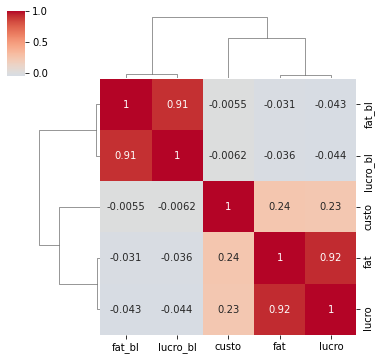

In [332]:
corrs = dados.drop(columns=['anomes', 'codcamp', 'codcliente', 'familia', 'grupo', 'subgrupo', 'gt', 'validade_de', 'validade_ate']).select_dtypes(include=np.number).corr(method = 'kendall')

# Heatmap entre as correlações
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0, annot=True, figsize=(5,5))

- Percebe-se que há uma maior correlação entre faturamento e lucro, seguido pelo faturamento e o lucro da baseline

In [333]:
dados.shape

(1619589, 14)

- A partir das correlações será elaborado um scatterplot para demonstrar outliers

<AxesSubplot:xlabel='fat', ylabel='lucro'>

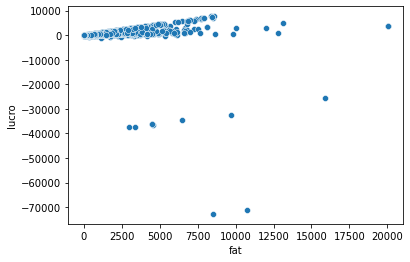

In [334]:
sns.scatterplot(data=dados, x="fat", y="lucro")

- O scatterplot mostra, de forma gráfica, valores que se distanciam da maioria (outliers), como por exemplo, os valores nos quais o lucro é menor que -20000.

##### Lucro menor que -20k

In [335]:
dados[dados['lucro'] < -20000]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
230780,2020-03-01,B0000000104,31119544,moto,rodas_pneus,premium,True,2020-03-16,2020-04-16,9721.98,39.99,-32425.64,16.84,0.000
570731,2020-04-01,B0000000122,31890657,moto,rodas_pneus,premium,True,2020-03-16,2020-04-16,3013.45,3475.00,-37465.30,3153.58,0.000
820203,2020-05-01,B0000000045,31611381,carro,rodas_pneus,basico,False,2020-05-21,2020-06-21,8516.60,100.50,-72780.46,31.64,0.000
843865,2020-05-01,B0000000104,01064932,moto,rodas_pneus,premium,True,2020-05-20,2020-06-20,4564.67,0.00,-36552.17,0.00,0.000
1140367,2020-06-01,B0000000014,32814573,carro,lataria_adesivacao,premium,True,2020-05-25,2020-06-25,15911.47,2765.99,-25793.64,2487.57,0.000
1518711,2020-06-01,B0000000107,20071288,moto,lataria_adesivacao,premium,True,2020-05-25,2020-06-25,3371.77,0.00,-37289.12,0.00,4.499
1607791,2020-06-01,B0000000472,31446848,carro,lataria_adesivacao,high_end,True,2020-05-15,2020-06-15,10745.74,0.00,-71016.55,0.00,0.000
1608974,2020-06-01,B0000000473,31198970,carro,estofamento_bancos,premium,True,2020-05-26,2020-06-26,4491.54,0.00,-36262.39,0.00,0.000
1611589,2020-06-01,B0000000475,31446848,carro,estofamento_bancos,high_end,True,2020-06-05,2020-07-05,6462.74,0.00,-34683.97,0.00,0.000
1617063,2020-06-01,B0000000484,31198970,carro,som,multimedia,True,2020-06-05,2020-07-05,4491.54,0.00,-36262.39,0.00,0.000


##### Retirando esses valores

In [336]:
dados = dados[dados['lucro'] > -20000]

<AxesSubplot:xlabel='fat', ylabel='lucro'>

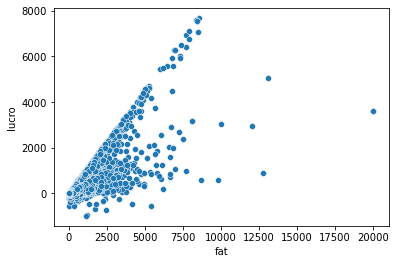

In [337]:
sns.scatterplot(data=dados, x="fat", y="lucro")

##### Lucro maior que 15000

In [338]:
dados[dados['fat'] > 15000]

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
1397411,2020-06-01,B0000000047,33090941,carro,som,multimedia,True,2020-06-05,2020-07-05,20038.78,590.84,3607.38,202.28,1142.58
1583302,2020-06-01,B0000000125,33090941,moto,lataria_adesivacao,premium,True,2020-05-25,2020-06-25,20038.78,590.84,3607.38,202.28,0.00


##### Retirando esses valores

In [339]:
dados = dados[dados['fat'] < 15000]

<AxesSubplot:xlabel='fat', ylabel='lucro'>

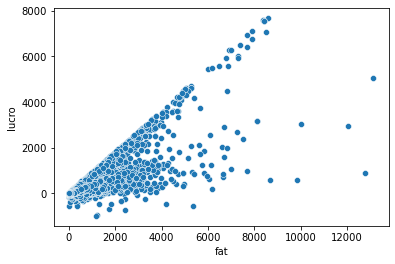

In [340]:
sns.scatterplot(data=dados, x="fat", y="lucro")

##### Repetindo com valores de fat_bl e lucro_bl

<AxesSubplot:xlabel='fat_bl', ylabel='lucro_bl'>

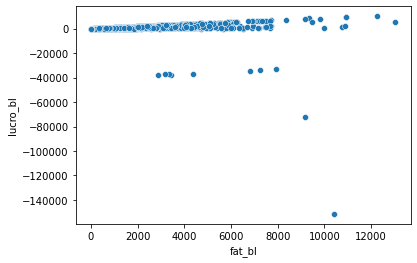

In [341]:
sns.scatterplot(data=dados, x="fat_bl", y="lucro_bl")

In [342]:
dados = dados[dados['lucro_bl'] > -20000]

<AxesSubplot:xlabel='fat_bl', ylabel='lucro_bl'>

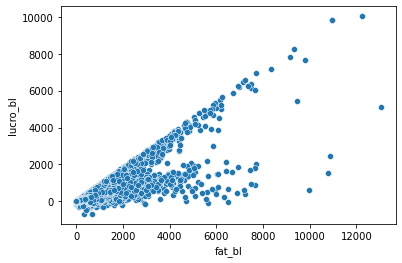

In [343]:
sns.scatterplot(data=dados, x="fat_bl", y="lucro_bl")

In [344]:
dados

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
1,2020-03-01,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,461.30,0.00,181.38,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
4,2020-03-01,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,220.56,0.00,27.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633229,2020-06-01,B0000000566,59568503,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,364.68,0.00,109.77,0.0
1633230,2020-06-01,B0000000566,59570312,moto,lataria_adesivacao,high_end,True,2020-05-18,2020-06-18,68.30,39.29,25.30,10.64,0.0
1633231,2020-06-01,B0000000566,59573779,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,43.88,0.00,19.30,0.00,0.0
1633232,2020-06-01,B0000000566,59573798,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,0.00,0.00,0.00,0.0


##### Salvando dataset para ser utilizado no Power BI

In [185]:
dados.to_csv('dados.csv')

_______

## Exploração dos dados

##### Tipos de famílias

In [186]:
dados['familia'].unique()

array(['carro', 'moto', 'caminhao', 'offroad'], dtype=object)

##### Tipos de grupos

In [187]:
dados['grupo'].unique()

array(['escapamento', 'rodas_pneus', 'som', 'lataria_adesivacao',
       'estofamento_bancos', 'cabine', 'carroceria',
       'equipamentos_trilha'], dtype=object)

##### Tipos de subgrupos

In [188]:
dados['subgrupo'].unique()

array(['esporte', 'esportivo', 'premium', 'basico', 'multimedia',
       'high_end', 'intermediario', 'lama', 'estrada'], dtype=object)

##### Quantidade de clientes

In [189]:
dados['codcliente'].nunique()

543255

##### Datas de ínicio das campanhas

In [190]:
dados['validade_de'].unique()

array(['2020-03-10T00:00:00.000000000', '2020-03-19T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-17T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-20T00:00:00.000000000',
       '2020-03-15T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-13T00:00:00.000000000', '2020-03-11T00:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
       '2020-03-12T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-22T00:00:00.000000000', '2020-05-19T00:00:00.000000000',
       '2020-05-20T00:00:00.000000000', '2020-05-21T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-25T00:00:00.000000000',
       '2020-05-15T00:00:00.000000000', '2020-05-26T00:00:00.000000000',
       '2020-06-11T00:00:00.000000000', '2020-06-05T00:00:00.000000000',
       '2020-06-12T00:00:00.000000000'], dtype='datetime64[ns]')

##### Datas finais das campanhas

In [191]:
dados['validade_ate'].unique()

array(['2020-04-10T00:00:00.000000000', '2020-04-19T00:00:00.000000000',
       '2020-04-16T00:00:00.000000000', '2020-04-17T00:00:00.000000000',
       '2020-04-14T00:00:00.000000000', '2020-04-20T00:00:00.000000000',
       '2020-04-15T00:00:00.000000000', '2020-04-09T00:00:00.000000000',
       '2020-04-13T00:00:00.000000000', '2020-04-11T00:00:00.000000000',
       '2020-04-18T00:00:00.000000000', '2020-04-23T00:00:00.000000000',
       '2020-04-12T00:00:00.000000000', '2020-04-21T00:00:00.000000000',
       '2020-04-22T00:00:00.000000000', '2020-06-19T00:00:00.000000000',
       '2020-06-20T00:00:00.000000000', '2020-06-21T00:00:00.000000000',
       '2020-06-18T00:00:00.000000000', '2020-06-25T00:00:00.000000000',
       '2020-06-15T00:00:00.000000000', '2020-06-26T00:00:00.000000000',
       '2020-07-11T00:00:00.000000000', '2020-07-05T00:00:00.000000000',
       '2020-07-12T00:00:00.000000000'], dtype='datetime64[ns]')

##### Quantidade de camapanhas diferentes

In [192]:
dados['codcamp'].nunique()

121

### Campanhas

##### Entendendo um pouco melhor a distribuição dos grupos teste e controle nas camapanhas

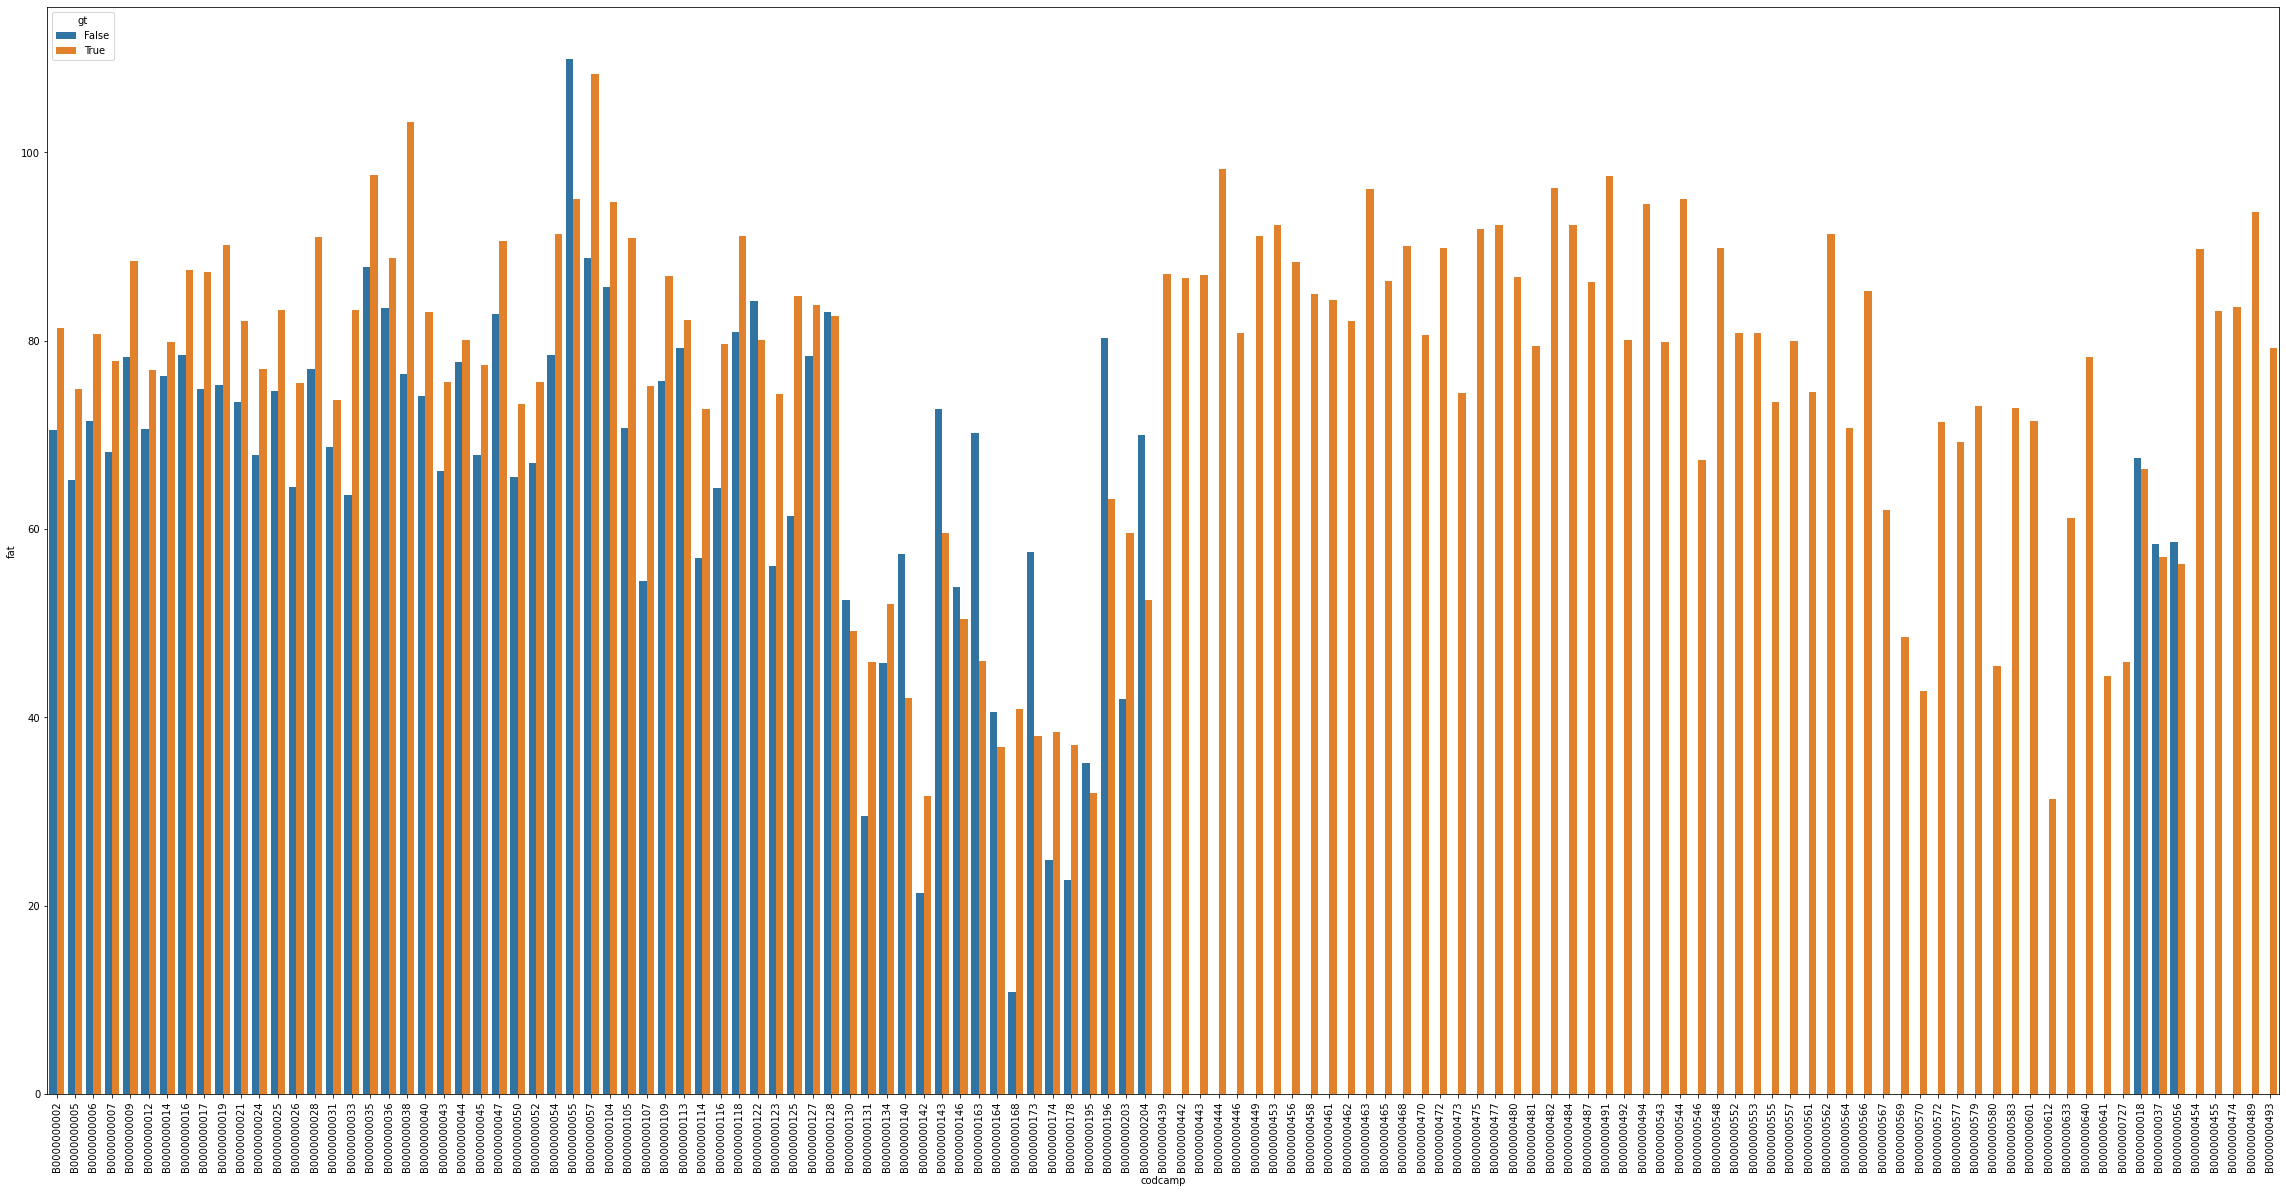

In [193]:
plt.figure(figsize=(40,20))
ax = sns.barplot(x="codcamp", y="fat", hue="gt", data=dados, ci=None)
plt.xticks(rotation = 90)
plt.show()

- <b>Dúvida:</b> Algumas campanhas não tem grupo controle. Por que?

##### Quantidade de campanhas que tem grupo teste e controle

In [194]:
com_controle = dados[dados['gt'] == False]
com_controle['codcamp'].nunique()

63

##### Crianda dataset apenas com campanhas que tenham grupo teste e controle

In [195]:
controle = com_controle['codcamp'].unique().tolist()
filtro = dados.codcamp.isin(controle)
dados_teste_controle = dados[filtro]
dados_teste_controle

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
1,2020-03-01,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,461.30,0.00,181.38,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
4,2020-03-01,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,220.56,0.00,27.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585042,2020-06-01,B0000000127,59645858,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,69.49,205.58,16.18,81.79,0.0
1585043,2020-06-01,B0000000127,59648713,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,32.26,0.00,13.01,0.0
1585044,2020-06-01,B0000000127,59649063,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,33.98,0.00,13.93,0.0
1585045,2020-06-01,B0000000127,59651669,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,177.88,0.00,58.95,0.0


##### Visualizando o novo dataset

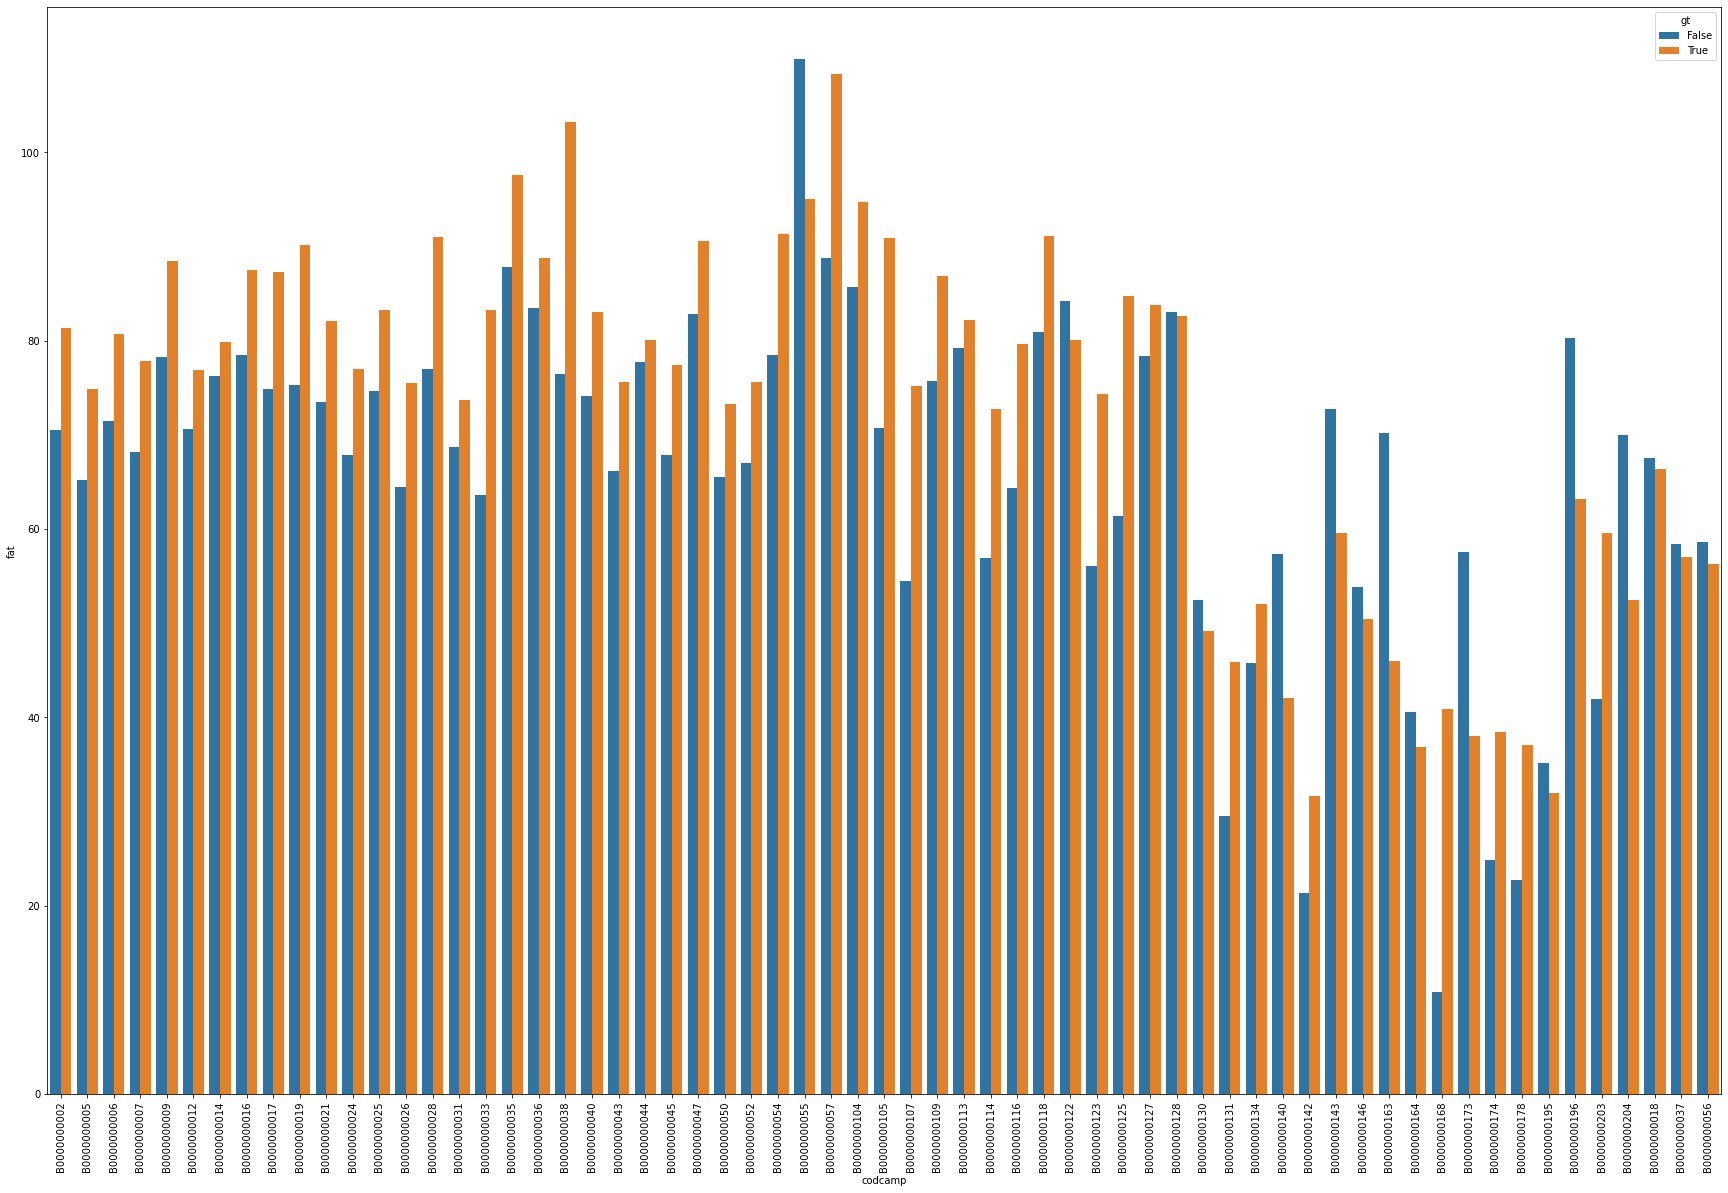

In [196]:
plt.figure(figsize=(30,20))
ax = sns.barplot(x="codcamp", y="fat", hue="gt", data=dados_teste_controle, ci=None)
plt.xticks(rotation = 90)
plt.show()

- Algumas campanhas tiveram resultados melhores que outras?

##### Salvando dataset com grupo teste e controle

In [197]:
dados_teste_controle.to_csv('dados_teste_controle.csv')

##### Entendendo a dica dada no projeto

Cliente com classe gt = “True” sem custo: cliente foi a loja porém não usou os descontos recebidos pela campanha

In [198]:
tg_true = dados[(dados['gt'] == True) & (dados['fat'] != 0) & (dados['custo'] == 0)]
tg_true

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
5,2020-03-01,B0000000002,00016992,carro,escapamento,esporte,True,2020-03-10,2020-04-10,304.95,5.39,116.34,2.69,0.0
6,2020-03-01,B0000000002,00019177,carro,escapamento,esporte,True,2020-03-10,2020-04-10,15.99,166.81,5.58,64.16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633225,2020-06-01,B0000000566,59565275,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,25.95,0.00,7.54,0.00,0.0
1633226,2020-06-01,B0000000566,59566437,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,237.99,0.00,18.21,0.00,0.0
1633227,2020-06-01,B0000000566,59566544,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,70.29,0.00,30.11,0.00,0.0
1633230,2020-06-01,B0000000566,59570312,moto,lataria_adesivacao,high_end,True,2020-05-18,2020-06-18,68.30,39.29,25.30,10.64,0.0


<b>Dúvida:</b> Por que o cliente não usou o cupom?
- Como o cupom foi mandado? 
- Email?
- Talvez recebeu a campanha mas os produtos que comprou não tinham desconto
- Talvez o cliente não sabia que havia um cupom para ser utilizado

___________________

- Não será retirado do dataset, pois talvez o fato de ter recebido a campanha motivou com que a pessoa fosse a loja e realizado uma compra, apesar de não ter utilizado os descontos.

### Família

##### Entendendo os grupos e subgrupos dentro das diferentes famílias

In [199]:
dados['familia'].unique()

array(['carro', 'moto', 'caminhao', 'offroad'], dtype=object)

#### Carros

In [200]:
carro = dados[dados['familia'] == 'carro']

##### Divisão de grupos de carros

In [201]:
carro['grupo'].unique()

array(['escapamento', 'rodas_pneus', 'som', 'lataria_adesivacao',
       'estofamento_bancos'], dtype=object)

##### Divisão de subgrupos de carros

In [202]:
carro['subgrupo'].unique()

array(['esporte', 'esportivo', 'premium', 'basico', 'multimedia',
       'high_end'], dtype=object)

##### Quantidade de campanhas utilizadas com o grupo carro

In [203]:
carro['codcamp'].nunique()

65

#### Motos

In [204]:
moto = dados[dados['familia'] == 'moto']

##### Divisão de grupos de motos

In [205]:
moto['grupo'].unique()

array(['rodas_pneus', 'lataria_adesivacao'], dtype=object)

##### Divisão de subgrupos de motos

In [206]:
moto['subgrupo'].unique()

array(['premium', 'basico', 'high_end'], dtype=object)

##### Quantidade de campanhas utilizadas com o grupo moto

In [207]:
moto['codcamp'].nunique()

24

#### Caminhão

In [208]:
caminhao = dados[dados['familia'] == 'caminhao']

##### Divisão de grupos de caminhões

In [209]:
caminhao['grupo'].unique()

array(['cabine', 'carroceria'], dtype=object)

##### Divisão de subgrupos de caminhões

In [210]:
caminhao['subgrupo'].unique()

array(['premium', 'intermediario', 'basico'], dtype=object)

##### Quantidade de campanhas utilizadas com o grupo caminhão

In [211]:
caminhao['codcamp'].nunique()

16

#### Offroad

In [212]:
offroad = dados[dados['familia'] == 'offroad']

##### Divisão de grupos de offroads

In [213]:
offroad['grupo'].unique()

array(['rodas_pneus', 'equipamentos_trilha'], dtype=object)

##### Divisão de subgrupos de offroads

In [214]:
offroad['subgrupo'].unique()

array(['lama', 'estrada', 'premium'], dtype=object)

##### Quantidade de campanhas utilizadas com o grupo offroad

In [215]:
offroad['codcamp'].nunique()

16

<b>Dúvida:</b> Uma campanha abrange mais de uma família?

In [216]:
faturamento_positivo = dados[dados['fat'] > 0]
familia_campanhas = faturamento_positivo.groupby(['codcamp', 'familia'])[['fat']].count().reset_index()
familia_campanhas

,codcamp,familia,fat
0,B0000000002,carro,29939
1,B0000000005,carro,30621
2,B0000000006,carro,30917
3,B0000000007,carro,40283
4,B0000000009,carro,33192
...,...,...,...
116,B0000000612,offroad,59
117,B0000000633,offroad,81
118,B0000000640,offroad,17
119,B0000000641,offroad,44


In [217]:
familia_campanhas['codcamp'].nunique()

121

- Uma campanha abrange apenas uma família

### Clientes

<b>Dúvida:</b> Um cliente pode aparecer mais de uma vez?

##### Número de clientes únicos

In [218]:
dados['codcliente'].nunique()

543255

##### Quantidade de clientes no dataset

In [219]:
dados['codcliente'].count()

1619567

- Um cliente aparece mais de uma vez

##### Analisando um cliente específico

In [220]:
cliente = dados[dados['codcliente'] == '00002658']
cliente

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.000
316746,2020-04-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,0.00,0.00,0.00,0.000
654427,2020-05-01,B0000000007,00002658,carro,rodas_pneus,basico,True,2020-05-21,2020-06-21,0.00,0.00,0.00,0.00,0.000
967228,2020-06-01,B0000000005,00002658,carro,rodas_pneus,esportivo,True,2020-06-11,2020-07-11,20.57,0.00,10.56,0.00,0.000
1029574,2020-06-01,B0000000007,00002658,carro,rodas_pneus,basico,True,2020-05-21,2020-06-21,20.57,31.98,10.56,18.10,0.458


<b>Dúvida:</b> Um cliente pode receber mais de uma campanha

In [221]:
faturamento_positivo = dados[dados['fat'] > 0]
cliente_groupby = faturamento_positivo.groupby(['codcliente', 'gt'])[['fat']].count().reset_index()
cliente_groupby = cliente_groupby.pivot_table('fat', ['codcliente'], 'gt')
cliente_groupby.reset_index(drop=False, inplace=True)
cliente_groupby[(cliente_groupby[False].notnull()) & (cliente_groupby[True].notnull())]

gt,codcliente,False,True
15,00002051,1.0,3.0
25,00002360,2.0,1.0
27,00002430,1.0,2.0
28,00002456,1.0,2.0
30,00002544,1.0,2.0
...,...,...,...
359447,TTT0038E,2.0,1.0
359451,TTT0038R,1.0,3.0
359452,TTT00391,1.0,3.0
359470,TTT003CR,1.0,2.0


In [222]:
cliente_true_false = dados[dados['codcliente'] == '00002051']
cliente_true_false

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
244848,2020-03-01,B0000000105,00002051,moto,rodas_pneus,basico,True,2020-03-17,2020-04-17,46.73,38.85,18.09,15.65,0.916
538163,2020-04-01,B0000000105,00002051,moto,rodas_pneus,basico,True,2020-03-17,2020-04-17,25.26,0.00,10.23,0.00,0.627
909649,2020-05-01,B0000000122,00002051,moto,rodas_pneus,premium,False,2020-05-20,2020-06-20,26.56,0.00,11.31,0.00,0.000
1556603,2020-06-01,B0000000116,00002051,moto,lataria_adesivacao,premium,True,2020-06-11,2020-07-11,25.86,26.56,10.16,11.31,3.798


- Um cliente pode estar no grupo teste e controle

### Datas

##### Meses de ínicio das campanhas

In [223]:
dados['validade_de'].dt.strftime("%b").unique().tolist()

['Mar', 'May', 'Jun']

##### Meses finais das campanhas

In [224]:
dados['validade_ate'].dt.strftime("%b").unique().tolist()

['Apr', 'Jun', 'Jul']

##### Ano de início das campanhas

In [225]:
dados['validade_de'].dt.strftime("%y").unique().tolist()

['20']

##### Ano final das campanhas

In [226]:
dados['validade_ate'].dt.strftime("%y").unique().tolist()

['20']

##### Ano e mês de disparo das campanhas

In [227]:
dados['anomes'].dt.strftime("%b").unique().tolist()

['Mar', 'Apr', 'May', 'Jun']

- Como as campanhas foram disparadas em meses diferentes, talvez o algortimo do último mês tenha se ajustado mais e as campanhas conseguiram entregar resultados melhores

## Análise Geral dos Resultados

- Para fazer o estudo geral das campanhas será calculado o ticket médio do grupo teste e do grupo controle, relacionando os dois grupos quando as campanhas ocorreram comparando com a baseline (quando as campanhas ainda não estavam ativas).

In [228]:
dados

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
1,2020-03-01,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,461.30,0.00,181.38,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
4,2020-03-01,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,220.56,0.00,27.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633229,2020-06-01,B0000000566,59568503,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,364.68,0.00,109.77,0.0
1633230,2020-06-01,B0000000566,59570312,moto,lataria_adesivacao,high_end,True,2020-05-18,2020-06-18,68.30,39.29,25.30,10.64,0.0
1633231,2020-06-01,B0000000566,59573779,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,43.88,0.00,19.30,0.00,0.0
1633232,2020-06-01,B0000000566,59573798,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,0.00,0.00,0.00,0.0


In [229]:
analise_geral = faturamento_positivo.groupby(['gt'])[['fat', 'lucro', 'custo']].sum().reset_index()
analise_geral_cliente = faturamento_positivo.groupby(['gt'])[['codcliente']].nunique().reset_index()
analise_geral_cliente = analise_geral_cliente.rename(columns={'codcliente': 'clientes'})
analise_geral = analise_geral.merge(analise_geral_cliente)
analise_geral

,gt,fat,lucro,custo,clientes
0,False,1.015407e+07,3635426.33,0.000,47630
1,True,1.201812e+08,43248163.89,692725.453,346242


- Agrupando os dados por quem recebeu a campanha e quem não recebeu, somando o faturamento, lucro, custo e quantidade de clientes que compraram no período das campanhas

In [230]:
faturamento_positivo_bl = dados[dados['fat_bl'] > 0]
analise_geral_bl = faturamento_positivo_bl.groupby(['gt'])[['fat_bl', 'lucro_bl']].sum().reset_index()
analise_geral_bl_cliente = faturamento_positivo_bl.groupby(['gt'])[['codcliente']].nunique().reset_index()
analise_geral_bl_cliente = analise_geral_bl_cliente.rename(columns={'codcliente': 'clientes_bl'})
analise_geral_bl = analise_geral_bl.merge(analise_geral_bl_cliente)
analise_geral_bl

,gt,fat_bl,lucro_bl,clientes_bl
0,False,1.510886e+07,5557521.24,71899
1,True,1.496473e+08,55054439.18,450164


- Agrupando os dados por quem recebeu a campanha e quem não recebeu, somando o faturamento da baseline, lucro da baseline, e quantidade de clientes que compraram no mês anterior as campanhas

In [231]:
analise_geral = analise_geral.merge(analise_geral_bl)
analise_geral

,gt,fat,lucro,custo,clientes,fat_bl,lucro_bl,clientes_bl
0,False,1.015407e+07,3635426.33,0.000,47630,1.510886e+07,5557521.24,71899
1,True,1.201812e+08,43248163.89,692725.453,346242,1.496473e+08,55054439.18,450164


- Juntando as duas tabelas

In [232]:
analise_geral['ticket_medio'] = analise_geral['fat'] / analise_geral['clientes']
analise_geral['ticket_medio_bl'] = analise_geral['fat_bl'] / analise_geral['clientes_bl']
analise_geral['lucro_medio'] = analise_geral['lucro'] / analise_geral['clientes']
analise_geral['lucro_medio_bl'] = analise_geral['lucro_bl'] / analise_geral['clientes_bl']
analise_geral['custo_medio'] = analise_geral['custo'] / analise_geral['clientes']
analise_geral['diferenca_ticket_medio'] = analise_geral['ticket_medio'] - analise_geral['ticket_medio_bl']
analise_geral['diferenca_lucro_medio'] = analise_geral['lucro_medio'] - analise_geral['lucro_medio_bl']
analise_geral['dif_lucro_menos_custo'] = analise_geral['diferenca_lucro_medio'] - analise_geral['custo_medio']
analise_geral

,gt,fat,lucro,custo,clientes,fat_bl,lucro_bl,clientes_bl,ticket_medio,ticket_medio_bl,lucro_medio,lucro_medio_bl,custo_medio,diferenca_ticket_medio,diferenca_lucro_medio,dif_lucro_menos_custo
0,False,1.015407e+07,3635426.33,0.000,47630,1.510886e+07,5557521.24,71899,213.186424,210.140087,76.326398,77.296224,0.000000,3.046337,-0.969827,-0.969827
1,True,1.201812e+08,43248163.89,692725.453,346242,1.496473e+08,55054439.18,450164,347.101878,332.428294,124.907330,122.298627,2.000697,14.673584,2.608703,0.608006


- Cálculo do ticket médio do período das campanhas e da baseline, assim como o lucro  médio e custo médio. Além disso, foi feita a diferença do ticket médio, lucro médio e custo médio do período das campanhas em relação a baseline

In [233]:
tabela_analise_geral = analise_geral[['gt', 'diferenca_ticket_medio', 'diferenca_lucro_medio', 'custo_medio', 'dif_lucro_menos_custo']]
tabela_analise_geral = tabela_analise_geral.set_index('gt')
tabela_analise_geral =  np.transpose(tabela_analise_geral)
tabela_analise_geral

gt,False,True
diferenca_ticket_medio,3.046337,14.673584
diferenca_lucro_medio,-0.969827,2.608703
custo_medio,0.000000,2.000697
dif_lucro_menos_custo,-0.969827,0.608006


- Selecionada apenas as colunas que foram calculadas e fazendo uma tranposição da tabela

In [234]:
tabela_analise_geral['comparacao_teste_controle'] = tabela_analise_geral[True] - tabela_analise_geral[False]
tabela_analise_geral = tabela_analise_geral.rename(columns={False: 'Controle', True: 'Teste'})
tabela_analise_geral

gt,Controle,Teste,comparacao_teste_controle
diferenca_ticket_medio,3.046337,14.673584,11.627247
diferenca_lucro_medio,-0.969827,2.608703,3.578530
custo_medio,0.000000,2.000697,2.000697
dif_lucro_menos_custo,-0.969827,0.608006,1.577832


- Calculando a diferença do grupo teste e controle para saber o real resultado gerado pelas campanhas

### Ticket Médio

- Nos meses que as campanhas foram enviadas, tanto o grupo controle como o teste tiveram aumento do ticket médio. O aumento do grupo controle foi de 3,05 reais e do grupo teste de 14,67, portanto o ticket médio do grupo que recebeu as campanhas teve um acréscimo de 11 reais e 63 centavos a mais do que o grupo que não recebeu as campanhas.

### Lucro médio por cliente

- O grupo que recebeu as campanhas teve um lucro de 2,61 reais por cliente, já o grupo que não recebeu teve um prejuízo de 97 centavos por cliente, ou seja, o grupo que recebeu as campanhas teve 3 reais e 58 centavos a mais de lucro por cliente do que os que não receberam.

### Custo por cliente

- O custo médio das campanhas por cliente foi de 2 reais. Além disso, o lucro líquido (lucro menos custo das campanhas) do grupo que recebeu as campanhas foi de 1 reais e 58 centavos a mais por pessoa, do que o grupo que não recebeu.

### Retorno sobre o Investimento (ROI)

$ROI = \frac{(Lucro - Investimento)}{Investimento}$

In [235]:
(analise_geral[analise_geral['gt'] == True]['lucro'].sum() - analise_geral[analise_geral['gt'] == True]['custo'].sum()) / analise_geral[analise_geral['gt'] == True]['custo'].sum()*100

6143.1896652135865

- O retorno que as campanhas obteram em relação ao custo investido foi de 6143,19%.

### Resultado Geral

- As campanhas tiveram resultados positivos, levando em conta a diferença de lucro líquido em relação ao grupo controle e também ao retorno sobre o investimento que indica que o investimento realizado retornou ao cliente.

## Análise por campanha

- Análise para saber quais campanhas dar seguimento caso o projeto seja continuado, deixando apenas aquelas campanhas que tiveram resultado positivo comparado com o grupo controle.

In [236]:
dados_teste_controle

,anomes,codcamp,codcliente,familia,grupo,subgrupo,gt,validade_de,validade_ate,fat,fat_bl,lucro,lucro_bl,custo
0,2020-03-01,B0000000002,00002658,carro,escapamento,esporte,True,2020-03-10,2020-04-10,31.98,132.06,17.53,63.34,0.0
1,2020-03-01,B0000000002,00002764,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,461.30,0.00,181.38,0.0
2,2020-03-01,B0000000002,00002792,carro,escapamento,esporte,True,2020-03-10,2020-04-10,108.25,86.97,49.51,39.66,0.0
3,2020-03-01,B0000000002,00002928,carro,escapamento,esporte,True,2020-03-10,2020-04-10,97.56,0.00,43.49,0.00,0.0
4,2020-03-01,B0000000002,00016656,carro,escapamento,esporte,True,2020-03-10,2020-04-10,0.00,220.56,0.00,27.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585042,2020-06-01,B0000000127,59645858,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,69.49,205.58,16.18,81.79,0.0
1585043,2020-06-01,B0000000127,59648713,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,32.26,0.00,13.01,0.0
1585044,2020-06-01,B0000000127,59649063,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,33.98,0.00,13.93,0.0
1585045,2020-06-01,B0000000127,59651669,moto,lataria_adesivacao,high_end,True,2020-06-05,2020-07-05,0.00,177.88,0.00,58.95,0.0


In [237]:
faturamento_positivo_teste_controle = dados_teste_controle[dados_teste_controle['fat'] > 0]
agrupar = faturamento_positivo_teste_controle.groupby(['codcamp','familia', 'gt'])[['lucro', 'custo']].sum().reset_index()
agrupar_cliente = faturamento_positivo_teste_controle.groupby(['codcamp', 'familia','gt'])[['codcliente']].nunique().reset_index()
agrupar_cliente = agrupar_cliente.rename(columns={'codcliente': 'clientes'})
agrupar = agrupar.merge(agrupar_cliente)
agrupar

,codcamp,familia,gt,lucro,custo,clientes
0,B0000000002,carro,False,158612.95,0.000,2104
1,B0000000002,carro,True,1867639.98,9409.157,22799
2,B0000000005,carro,False,157386.97,0.000,2151
3,B0000000005,carro,True,1860884.97,7014.127,23029
4,B0000000006,carro,False,157975.68,0.000,2052
...,...,...,...,...,...,...
121,B0000000196,offroad,True,14023.02,11.588,200
122,B0000000203,offroad,False,2125.61,0.000,37
123,B0000000203,offroad,True,26575.76,174.390,410
124,B0000000204,offroad,False,4300.23,0.000,49


In [238]:
faturamento_bl_positivo = dados_teste_controle[dados_teste_controle['fat_bl'] > 0]
agrupar_bl = faturamento_bl_positivo.groupby(['codcamp', 'familia', 'gt'])[['lucro_bl']].sum().reset_index()
agrupar_bl_cliente = faturamento_bl_positivo.groupby(['codcamp', 'familia', 'gt'])[['codcliente']].nunique().reset_index()
agrupar_bl_cliente = agrupar_bl_cliente.rename(columns={'codcliente': 'clientes_bl'})
agrupar_bl = agrupar_bl.merge(agrupar_bl_cliente)
agrupar_bl

,codcamp,familia,gt,lucro_bl,clientes_bl
0,B0000000002,carro,False,236573.56,3223
1,B0000000002,carro,True,2448133.24,31672
2,B0000000005,carro,False,281844.17,3631
3,B0000000005,carro,True,2727519.55,34571
4,B0000000006,carro,False,230551.14,3126
...,...,...,...,...,...
121,B0000000196,offroad,True,26242.00,307
122,B0000000203,offroad,False,3380.73,62
123,B0000000203,offroad,True,36170.52,598
124,B0000000204,offroad,False,3141.95,64


In [239]:
agrupar = agrupar.merge(agrupar_bl)
agrupar

,codcamp,familia,gt,lucro,custo,clientes,lucro_bl,clientes_bl
0,B0000000002,carro,False,158612.95,0.000,2104,236573.56,3223
1,B0000000002,carro,True,1867639.98,9409.157,22799,2448133.24,31672
2,B0000000005,carro,False,157386.97,0.000,2151,281844.17,3631
3,B0000000005,carro,True,1860884.97,7014.127,23029,2727519.55,34571
4,B0000000006,carro,False,157975.68,0.000,2052,230551.14,3126
...,...,...,...,...,...,...,...,...
121,B0000000196,offroad,True,14023.02,11.588,200,26242.00,307
122,B0000000203,offroad,False,2125.61,0.000,37,3380.73,62
123,B0000000203,offroad,True,26575.76,174.390,410,36170.52,598
124,B0000000204,offroad,False,4300.23,0.000,49,3141.95,64


In [240]:
agrupar['lucro/cliente'] = agrupar['lucro'] / agrupar['clientes']
agrupar['lucro_bl/cliente_bl'] = agrupar['lucro_bl'] / agrupar['clientes_bl']
agrupar['custo/cliente'] = agrupar['custo'] / agrupar['clientes']
agrupar

,codcamp,familia,gt,lucro,custo,clientes,lucro_bl,clientes_bl,lucro/cliente,lucro_bl/cliente_bl,custo/cliente
0,B0000000002,carro,False,158612.95,0.000,2104,236573.56,3223,75.386383,73.401663,0.000000
1,B0000000002,carro,True,1867639.98,9409.157,22799,2448133.24,31672,81.917627,77.296452,0.412700
2,B0000000005,carro,False,157386.97,0.000,2151,281844.17,3631,73.169210,77.621639,0.000000
3,B0000000005,carro,True,1860884.97,7014.127,23029,2727519.55,34571,80.806156,78.896172,0.304578
4,B0000000006,carro,False,157975.68,0.000,2052,230551.14,3126,76.986199,73.752764,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
121,B0000000196,offroad,True,14023.02,11.588,200,26242.00,307,70.115100,85.478827,0.057940
122,B0000000203,offroad,False,2125.61,0.000,37,3380.73,62,57.448919,54.527903,0.000000
123,B0000000203,offroad,True,26575.76,174.390,410,36170.52,598,64.818927,60.485819,0.425341
124,B0000000204,offroad,False,4300.23,0.000,49,3141.95,64,87.759796,49.092969,0.000000


In [241]:
agrupar['lucro - lucro_bl - custo'] = agrupar['lucro/cliente'] - agrupar['lucro_bl/cliente_bl'] - agrupar['custo/cliente']
agrupar = agrupar[['codcamp', 'familia', 'gt', 'lucro - lucro_bl - custo']]
agrupar

,codcamp,familia,gt,lucro - lucro_bl - custo
0,B0000000002,carro,False,1.984720
1,B0000000002,carro,True,4.208474
2,B0000000005,carro,False,-4.452429
3,B0000000005,carro,True,1.605406
4,B0000000006,carro,False,3.233435
...,...,...,...,...
121,B0000000196,offroad,True,-15.421667
122,B0000000203,offroad,False,2.921016
123,B0000000203,offroad,True,3.907766
124,B0000000204,offroad,False,38.666827


In [242]:
camp_groupby = agrupar.pivot_table('lucro - lucro_bl - custo', ['codcamp'], 'gt')
camp_groupby.reset_index(drop=False, inplace=True)
camp_groupby

gt,codcamp,False,True
0,B0000000002,1.984720,4.208474
1,B0000000005,-4.452429,1.605406
2,B0000000006,3.233435,2.523484
3,B0000000007,-0.424902,2.066543
4,B0000000009,-3.802711,-0.316773
...,...,...,...
58,B0000000178,31.224242,-8.675642
59,B0000000195,-9.871143,-8.894367
60,B0000000196,-38.714595,-15.421667
61,B0000000203,2.921016,3.907766


In [243]:
camp_groupby['diferenca de lucro menos custo'] = camp_groupby[True] - camp_groupby[False]
camp_groupby

gt,codcamp,False,True,diferenca de lucro menos custo
0,B0000000002,1.984720,4.208474,2.223754
1,B0000000005,-4.452429,1.605406,6.057835
2,B0000000006,3.233435,2.523484,-0.709951
3,B0000000007,-0.424902,2.066543,2.491445
4,B0000000009,-3.802711,-0.316773,3.485938
...,...,...,...,...
58,B0000000178,31.224242,-8.675642,-39.899884
59,B0000000195,-9.871143,-8.894367,0.976776
60,B0000000196,-38.714595,-15.421667,23.292927
61,B0000000203,2.921016,3.907766,0.986750


In [244]:
campanhas_positivas = camp_groupby[camp_groupby['diferenca de lucro menos custo'] > 0]
campanhas_positivas.sort_values(by=['diferenca de lucro menos custo'], ascending=False)

gt,codcamp,False,True,diferenca de lucro menos custo
60,B0000000196,-38.714595,-15.421667,23.292927
50,B0000000142,-21.790489,-0.989847,20.800642
55,B0000000168,-19.976340,-3.174285,16.802055
49,B0000000140,-0.960887,15.818392,16.779280
10,B0000000019,-12.705822,-0.577504,12.128318
25,B0000000045,-9.083110,1.164074,10.247185
40,B0000000118,-12.879896,-4.072695,8.807201
57,B0000000174,-16.075926,-8.183831,7.892095
27,B0000000050,-7.652779,-0.090113,7.562666
28,B0000000052,-5.457517,1.620853,7.078369


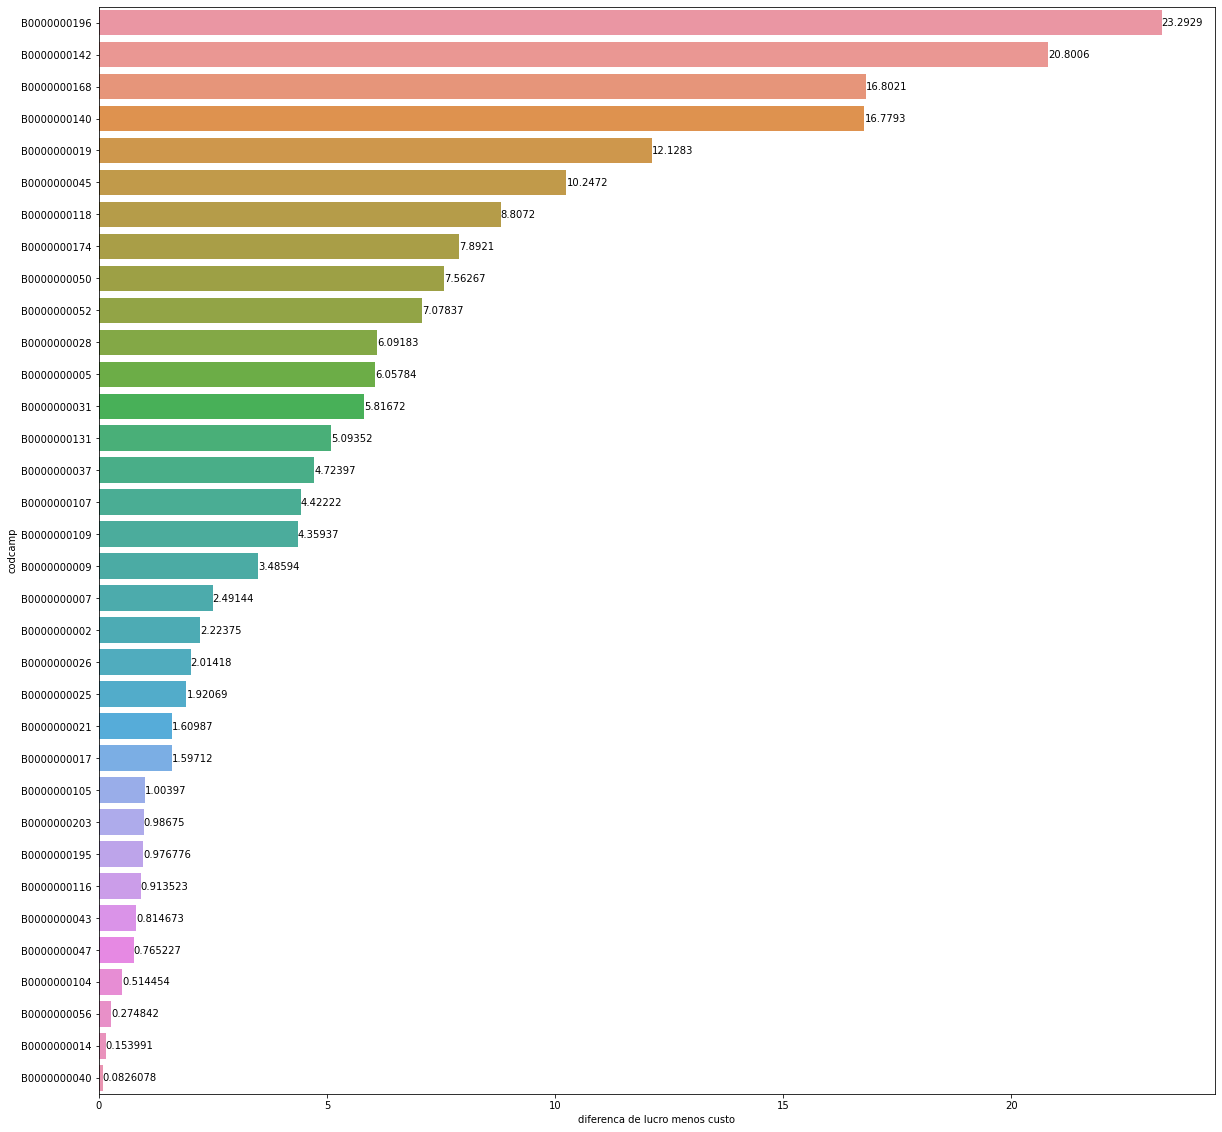

In [245]:
plt.figure(figsize=(20,20))
ax = sns.barplot(x="diferenca de lucro menos custo", y="codcamp", 
                 data=campanhas_positivas, 
                 order=campanhas_positivas.sort_values('diferenca de lucro menos custo', 
                                                       ascending = False).codcamp)
ax.bar_label(ax.containers[0])
plt.show()

- Essas são as campanhas que deram lucro em relação ao grupo controle, já subtraído os descontos com as campanhas.

## Análise por família

- Separando as campanhas por família a fim de saber quais foram as melhores

In [246]:
familia_groupby = agrupar.pivot_table('lucro - lucro_bl - custo', ['familia', 'codcamp'], 'gt')
familia_groupby.reset_index(drop=False, inplace=True)
familia_groupby['diferenca de lucro menos custo'] = familia_groupby[True] - familia_groupby[False]
familia_groupby

gt,familia,codcamp,False,True,diferenca de lucro menos custo
0,caminhao,B0000000128,28.643182,5.308712,-23.334469
1,caminhao,B0000000130,1.202251,-22.091890,-23.294141
2,caminhao,B0000000131,3.675444,8.768961,5.093516
3,caminhao,B0000000134,20.377595,10.578564,-9.799030
4,caminhao,B0000000140,-0.960887,15.818392,16.779280
...,...,...,...,...,...
58,offroad,B0000000178,31.224242,-8.675642,-39.899884
59,offroad,B0000000195,-9.871143,-8.894367,0.976776
60,offroad,B0000000196,-38.714595,-15.421667,23.292927
61,offroad,B0000000203,2.921016,3.907766,0.986750


In [247]:
familia_groupby.sort_values(by=['diferenca de lucro menos custo'], ascending=False)

gt,familia,codcamp,False,True,diferenca de lucro menos custo
60,offroad,B0000000196,-38.714595,-15.421667,23.292927
5,caminhao,B0000000142,-21.790489,-0.989847,20.800642
55,offroad,B0000000168,-19.976340,-3.174285,16.802055
4,caminhao,B0000000140,-0.960887,15.818392,16.779280
18,carro,B0000000019,-12.705822,-0.577504,12.128318
...,...,...,...,...,...
0,caminhao,B0000000128,28.643182,5.308712,-23.334469
56,offroad,B0000000173,35.934000,4.393463,-31.540537
62,offroad,B0000000204,38.666827,-0.888269,-39.555096
58,offroad,B0000000178,31.224242,-8.675642,-39.899884


In [248]:
carro = familia_groupby[familia_groupby['familia'] == 'carro']
carro = carro[carro['diferenca de lucro menos custo'] > 0]

offroad = familia_groupby[familia_groupby['familia'] == 'offroad']
offroad = offroad[offroad['diferenca de lucro menos custo'] > 0]

caminhao = familia_groupby[familia_groupby['familia'] == 'caminhao']
caminhao = caminhao[caminhao['diferenca de lucro menos custo'] > 0]

moto = familia_groupby[familia_groupby['familia'] == 'moto']
moto = moto[moto['diferenca de lucro menos custo'] > 0]

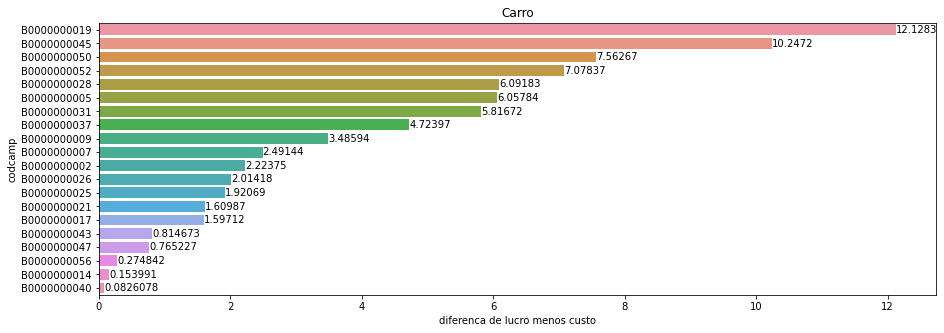

In [249]:
plt.figure(figsize=(15,5))
plt.title('Carro')
ax = sns.barplot(x="diferenca de lucro menos custo", y="codcamp", 
                 data=carro, 
                 order=carro.sort_values('diferenca de lucro menos custo', 
                                                       ascending = False).codcamp)
ax.bar_label(ax.containers[0])
plt.show()

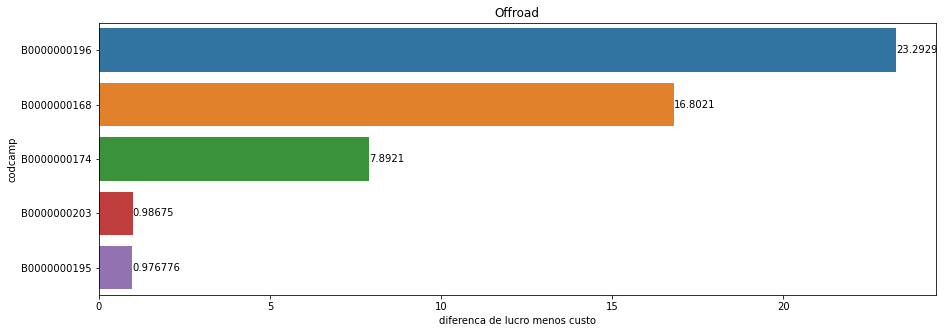

In [250]:
plt.figure(figsize=(15,5))
plt.title('Offroad')
ax = sns.barplot(x="diferenca de lucro menos custo", y="codcamp", 
                 data=offroad, 
                 order=offroad.sort_values('diferenca de lucro menos custo', 
                                                       ascending = False).codcamp)
ax.bar_label(ax.containers[0])
plt.show()

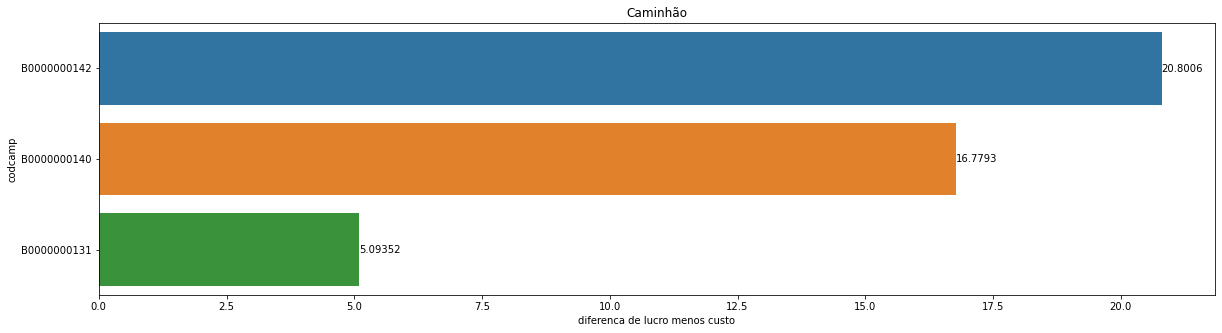

In [251]:
plt.figure(figsize=(20,5))
plt.title('Caminhão')
ax = sns.barplot(x="diferenca de lucro menos custo", y="codcamp", 
                 data=caminhao, 
                 order=caminhao.sort_values('diferenca de lucro menos custo', 
                                                       ascending = False).codcamp)
ax.bar_label(ax.containers[0])
plt.show()

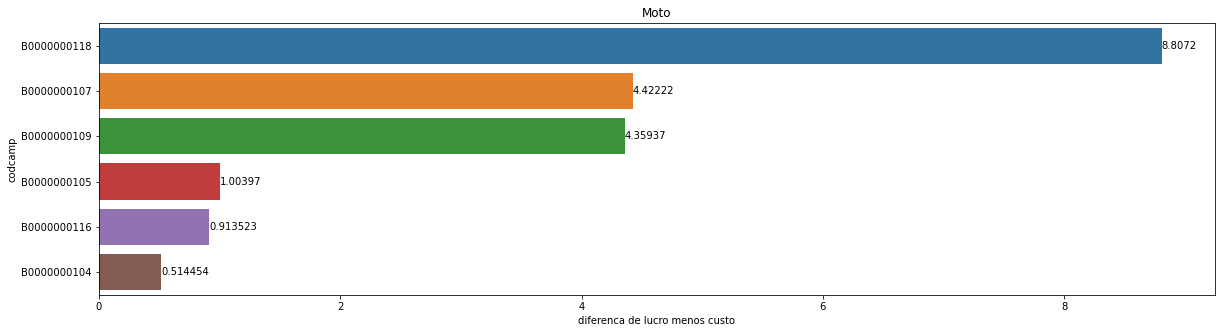

In [252]:
plt.figure(figsize=(20,5))
plt.title('Moto')
ax = sns.barplot(x="diferenca de lucro menos custo", y="codcamp", 
                 data=moto, 
                 order=moto.sort_values('diferenca de lucro menos custo', 
                                                       ascending = False).codcamp)
ax.bar_label(ax.containers[0])
plt.show()